In [1]:
import glob
import gpxpy
import pyproj
import os
import requests
import re

import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

In [2]:
osm_file = '../osm/strava.osm'

In [3]:
def get_gpx_df(gpx_file):
    with open(gpx_file, 'r') as file:
        gpx = gpxpy.parse(file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                })

    df = pd.DataFrame(data)

    df['prev_latitude'] = df['latitude'].shift(1)
    df['prev_longitude'] = df['longitude'].shift(1)
    
    g = pyproj.Geod(ellps='WGS84')
    
    df['fwd_azimuth'] = df.apply(
        lambda x: g.inv(x['prev_longitude'], x['prev_latitude'], x['longitude'], x['latitude'])[0] if not pd.isna(x['prev_latitude']) and not pd.isna(x['prev_longitude']) else 0, 
        axis=1,
    )
    df['fwd_azimuth'] = df['fwd_azimuth'].apply(lambda x: x + 360 if x < 0 else x)
    
    df['fwd_azimuth_delta'] = df['fwd_azimuth'].diff()
    
    df = df.drop(columns=[
        'prev_latitude', 
        'prev_longitude',
        'fwd_azimuth'
    ])
    
    return df

In [4]:
def plot_gpx(df, ax, label):
    ax.plot(df['longitude'], df['latitude'], color='red', label=label)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

In [5]:
def get_nearest(coords):
    lat, lon = coords
    response = requests.get(f"http://127.0.0.1:6000/nearest/v1/foot/{lon},{lat}")
    response.raise_for_status()

    df = pd.DataFrame(columns=['latitude', 'longitude', 'node_id'])
    
    data = response.json()
    if 'waypoints' in data:
        waypoints = data['waypoints']
        lat_long = [(wp['location'][1], wp['location'][0], wp['nodes'][0]) for wp in waypoints]
        df = pd.DataFrame(lat_long, columns=['latitude', 'longitude', 'node_id'])
    
    return df

In [6]:
def query_osrm(df, filename):
    results = []
    
    for index, row in turns_df.iterrows():
        coords = (row['latitude'], row['longitude'])
        nearest_df = get_nearest(coords)
        nearest_df['filename'] = filename
        results.append(nearest_df)

    return pd.concat(results).reset_index(drop=True)   

In [11]:
def create_osm(df, osm_file):
    osm = ET.Element("osm")
    osm.set("version", "0.6")
    osm.set("generator", "CGImap 0.9.2 (596732 spike-08.openstreetmap.org)")
    osm.set("copyright", "OpenStreetMap and contributors")
    osm.set("attribution", "http://www.openstreetmap.org/copyright")
    osm.set("license", "http://opendatacommons.org/licenses/odbl/1-0/")

    nodes_df = df\
    .drop_duplicates(subset=['node_id'])\
    .sort_values(by='node_id')

    for idx, row in nodes_df.iterrows():
        node_id = row["node_id"]

        ET.SubElement(
            osm,
            "node",
            id=str(node_id),
            lat=str(row["latitude"]),
            lon=str(row["longitude"]),
            visible="true",
            version="1",        
        )

    tags = [
          {"k": "highway", "v": "footway"},
          {"k": "footway", "v": "sidewalk"}
      ]

    ways_df = df.groupby('filename')['node_id'].agg(lambda x: list(x.unique())).reset_index()
    
    for idx, row in ways_df.iterrows():
        way_id = int(re.search(r'\d+', row['filename']).group())

        way = ET.SubElement(
            osm,
            "way",
            id=str(way_id),
            visible="true",
            version="1",
        )

        for node_id in row["node_id"]:
            nd = ET.SubElement(way, "nd")
            nd.set("ref", str(node_id))

        for tag_data in tags:
            tag = ET.SubElement(way, "tag")
            tag.set("k", tag_data["k"])
            tag.set("v", tag_data["v"]) 

        xml_str = minidom.parseString(ET.tostring(osm)).toprettyxml(indent="  ")

    with open(osm_file, "w") as f:
          f.write(xml_str)

Points count: 2981 vs 907


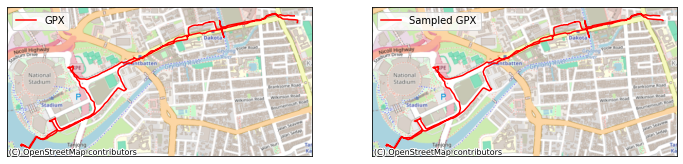

Points count: 6026 vs 1555


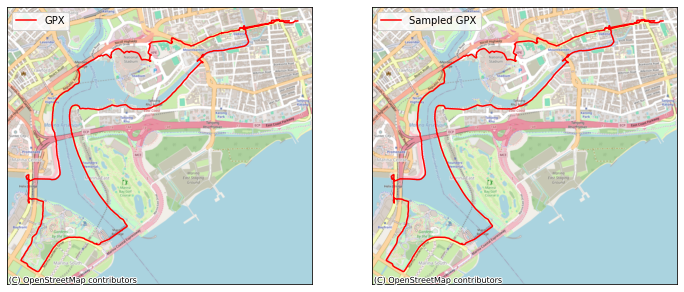

Points count: 5664 vs 1393


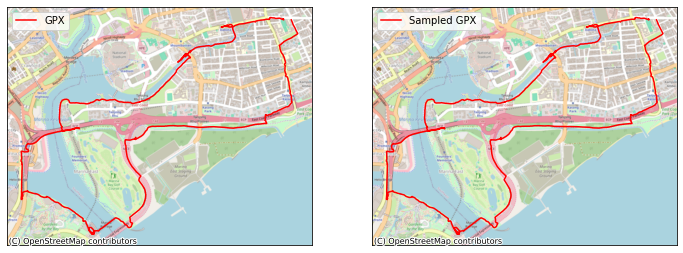

In [15]:
osrm_dfs = []

folder_path = '../data/'
gpx_files = glob.glob(os.path.join(folder_path, '*.gpx'))

for gpx_file in gpx_files:
    filename = os.path.basename(gpx_file)
    
    df = get_gpx_df(gpx_file)
    turns_df = df[abs(df['fwd_azimuth_delta']) >= 10]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    plot_gpx(df, ax1, 'GPX')
    plot_gpx(turns_df, ax2, 'Sampled GPX')
    
    print('Points count:', df.shape[0], 'vs' ,turns_df.shape[0])
    
    osrm_df = query_osrm(turns_df, filename)
    osrm_dfs.append(osrm_df)
    
    plt.show()

all_osrm_dfs = pd.concat(osrm_dfs).reset_index(drop=True)   

create_osm(
    all_osrm_dfs,
    osm_file,
)